In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|export
# Python native modules
import os
from torch.multiprocessing import Queue
# Third party libs
from fastcore.all import *
import matplotlib.pyplot as plt
import torchdata.datapipes as dp
from IPython.core.display import clear_output
# Local modules
from fastrl.core import *
from fastrl.loggers.core import *
from fastai.torch_basics import*

In [3]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [4]:
#|default_exp loggers.jupyter_visualizers

# Visualizers 
> Iterable pipes for displaying environments as they run using `typing.NamedTuples` with `image` fields

In [5]:
#|export
class SimpleJupyterVideoPlayer(LoggerBase):
    def __init__(self, 
                 source_datapipe=None, 
                 between_frame_wait_seconds:float=0.1
        ):
        super().__init__(source_datapipe)
        self.source_datapipe = source_datapipe
        self.between_frame_wait_seconds = 0.1
        
    def __iter__(self) -> typing.Tuple[typing.NamedTuple]:
        img = None
        for record in self.source_datapipe:
            for o in self.dequeue():
                if o.value is None: continue
                if img is None: img = plt.imshow(o.value)
                img.set_data(o.value) 
                plt.axis('off')
                display(plt.gcf())
                clear_output(wait=True)
            yield record
add_docs(
    SimpleJupyterVideoPlayer,
    """Displays video from a `source_datapipe` that produces `typing.NamedTuples` that contain an `image` field.
       This only can handle 1 env input.""",
    dequeue="Grabs records from the `main_queue` and attempts to display them"
)

In [6]:
#|export
class ImageCollector(LogCollector):
    def convert_np(self,o):
        if isinstance(o,Tensor):       return to_np(o)
        elif isinstance(o,np.ndarray): return o
        else:                          raise ValueError(f'Expects Tensor or np.ndarray not {type(o)}')
    
    def __iter__(self):
        for q in self.main_buffers: q.append(Record('image',None))
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    for q in self.main_buffers: 
                        q.append(Record('image',self.convert_np(step.image)))
            else:
                for q in self.main_buffers: q.append(Record('image',self.convert_np(steps.image)))
            yield steps

In [7]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,seed=seed,include_images=True)
    return pipe

In [8]:
%matplotlib inline

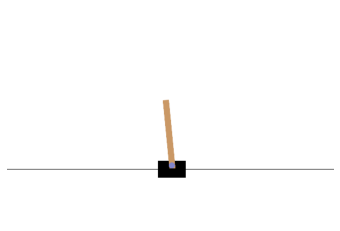

In [9]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],100)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [10]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/opt/conda/lib/python3.7/site-packages/astroid/node_classes.py:96: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  DeprecationWarning,
